In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
from functools import partial
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedBrokenTopK
from torch_perturb.perturbations import perturbed
import time
from torch_training import train_epoch_largesynth, train_epoch_largesynth_loo
from torch_models import torch_bpr_uncurried, deterministic_bpr
from metrics import top_k_onehot_indicator

2024-09-17 12:15:05.897195: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 12:15:05.946944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 12:15:05.946975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 12:15:05.948290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 12:15:05.956582: I tensorflow/core/platform/cpu_feature_guar

 We have $T$ training examples $\boldsymbol{y}_t, \boldsymbol{y} \in \mathbb{R}^S$

 We are interested in training a model $p_\phi(\boldsymbol{y})$ with parameters $\phi \in \mathbb{R}^P$ in order to optimize the Best Possible Reach at $K$ of a specific rating $\boldsymbol{r}$.

 The rating $\boldsymbol{r}$ is a function of some decision-making process $f$, so we can write the rating as the expected value of our decision-making process under the learned distribution of the data:
 $$ \boldsymbol{r}_t = \mathbb{E}_{\boldsymbol{y} \sim p_\phi}[f(\boldsymbol{y}_t)]$$

 We can frame this problem this as a standard machine learning task with objective, where we seek to minimize _negative_ BPR-K
 $$\mathcal{L}(y_t, \phi) = - BPR_K(\boldsymbol{r}_t, y_t)$$

 In order train our model, we use gradient descent to update the parameters, iteratively applying the following equation with step size $\lambda$:
 $$ \phi \leftarrow \lambda \frac{d\mathcal{L}}{d\phi}$$

We decompose the update in the following way and I don't know why- we could use the REINFORCE gradient estimator for the whole thing but instead we only use it for half. Probably because it's high variance and we have a better gradient estimator for $\frac{d\mathcal{L}}{d\boldsymbol{r}} $
 $$\frac{d\mathcal{L}}{d\phi} = \frac{d\boldsymbol{r}}{d\phi} \frac{d\mathcal{L}}{d\boldsymbol{r}} $$

 Here, because $\phi \in \mathbb{R}^P$,
 $\frac{d\mathcal{L}}{d\phi}$ is a length $P$ vector, $\frac{d\boldsymbol{r}}{d\phi}$ is a $P$-by-$S$ matrix, and $\frac{d\mathcal{L}}{d\boldsymbol{r}}$ is length $S$ vector.

In [2]:
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'

step_size=0.1
perturbed_noise=0.001
K=100
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_band.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_band.csv'))
num_score_samples = 50
num_pert_samples = 200
bpr_weight=30
nll_weight=0
frames = 10

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


In [3]:
example_time = 25

Text(0.5, 1.0, 'Data at time 25')

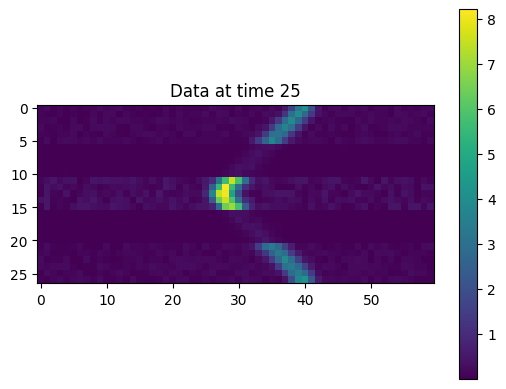

In [4]:
plt.imshow(deaths_TS[example_time,:].reshape(data_shape))
plt.colorbar()
plt.title(f'Data at time {example_time}')

In [5]:
good_exp = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_4000/bw0_nw1_ss0.1_nss100_nps100'
model = SpatialWaves(num_waves=1, low=0, high=100000)
model.load_state_dict(torch.load(good_exp + '/model.pth'))

<All keys matched successfully>

In [6]:

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func

top_k_func = partial(top_k_onehot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)#PerturbedBrokenTopK(k=K, sigma=perturbed_noise, num_samples=num_pert_samples)#

In [7]:
arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softplusinv_magnitudes, softplusinv_peak_widths = model.single_tensor_to_params(model.params_to_single_tensor())

In [8]:
def get_grads(model, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, ):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

    # Control variates
    #all_sample_tot = ratio_rating_TMS.sum(dim=-2, keepdim=True)
    #all_other_sample_mean = (all_sample_tot-ratio_rating_TMS)/(T-1)
    #score_func_estimator_TMSP = jac_TMSP * (ratio_rating_TMS - all_other_sample_mean).unsqueeze(-1)
    #score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    


    score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

    # get gradient of negative bpr_t  with respect to ratio rating_TS

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
    if nll_weight>0:
        bpr_threshold_diff_T = positive_bpr_T - threshold
        violate_threshold_flag = bpr_threshold_diff_T < 0
        negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    else:
        negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    loss.backward()
    loss_grad_TS = ratio_rating_TS.grad
    dLdr_TS = loss_grad_TS.detach().numpy()

    score_func_grad_P = torch.sum(score_func_estimator_TSP, dim=[0,1]).detach()
    drdphi_TSP = score_func_estimator_TSP.detach().numpy()
 
    gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
    gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    gradient_tuple = model.single_tensor_to_params(gradient_P)

    for param, gradient in zip(model.parameters(), gradient_tuple):
        if nll_weight>0:
            gradient = gradient + param.grad
        param.grad = gradient

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    return dLdr_TS, drdphi_TSP, deterministic_bpr_T,  positive_bpr_T, ratio_rating_TS.detach().numpy()

In [9]:
def get_grads_all_REINFORCE(model, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, ):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

    # Control variates
    #all_sample_tot = ratio_rating_TMS.sum(dim=-2, keepdim=True)
    #all_other_sample_mean = (all_sample_tot-ratio_rating_TMS)/(T-1)
    #score_func_estimator_TMSP = jac_TMSP * (ratio_rating_TMS - all_other_sample_mean).unsqueeze(-1)
    #score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    
    positive_bpr_TM = torch_bpr_uncurried(ratio_rating_TMS, torch.tensor(train_y_TS).unsqueeze(-2), K=K, perturbed_top_K_func=perturbed_top_K_func)

    # THIS IS A LIE, NEEDS PER-SAMPLE BPR
    score_func_estimator_TMSP = jac_TMSP * -positive_bpr_TM.unsqueeze(-1).unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    
    positive_bpr_T = positive_bpr_TM.mean(dim=1)

    # get gradient of negative bpr_t  with respect to ratio rating_TS

    #if nll_weight>0:
    #    bpr_threshold_diff_T = positive_bpr_T - threshold
    #    violate_threshold_flag = bpr_threshold_diff_T < 0
    #    negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    #else:
    #    negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    #nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    #loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    #loss.backward()
    #loss_grad_TS = ratio_rating_TS.grad
    dLdr_TS = np.zeros((T,S))

    #score_func_grad_P = torch.sum(score_func_estimator_TSP, dim=[0,1]).detach()
    drdphi_TSP = score_func_estimator_TSP.detach().numpy()
 
    #gradient_TSP = score_func_estimator_TSP #* torch.unsqueeze(loss_grad_TS, -1)
    #gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    #gradient_tuple = model.single_tensor_to_params(gradient_P)

    #for param, gradient in zip(model.parameters(), gradient_tuple):
    #    if nll_weight>0:
    #        gradient = gradient + param.grad
    #    param.grad = gradient

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    #det_bpr =torch.mean(deterministic_bpr_T)

    return dLdr_TS, drdphi_TSP, deterministic_bpr_T,  positive_bpr_T, ratio_rating_TS.detach().numpy()

In [10]:

dLdr_TSs= []
drdphi_TSPs = []
det_bprs, pert_bprs, rs = [], [], []
for softinv_peak_width in np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, frames):
    print(softinv_peak_width)
    model = SpatialWaves(num_waves=1, low=0, high=100000)
    model.load_state_dict(torch.load(good_exp + '/model.pth'))
    model.update_params(torch.cat([arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softplusinv_magnitudes, torch.tensor(softinv_peak_width).reshape(1)]))

    dLdr_TS, drdphi_TSP, deterministic_bpr_T,  positive_bpr_T, ratio_rating_TS = get_grads_all_REINFORCE(model, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)
    dLdr_TSs.append(dLdr_TS)
    drdphi_TSPs.append(drdphi_TSP)
    det_bprs.append(deterministic_bpr_T)
    pert_bprs.append(positive_bpr_T)
    rs.append(ratio_rating_TS)

[0.44006485]


/tmp/ipykernel_36525/1153696904.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/tmp/ipykernel_36525/1153696904.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


[0.53785706]
[0.6356492]
[0.73344135]
[0.83123356]
[0.92902577]
[1.0268179]
[1.1246102]
[1.2224023]
[1.3201945]


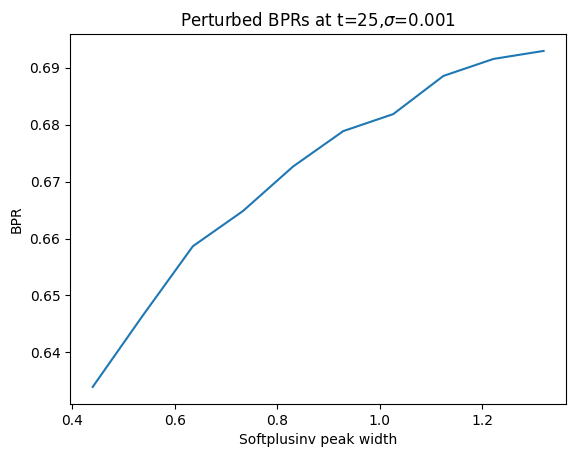

In [11]:
# Plot perturbed BPRs at the example time
plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, frames),
         [pert_bpr.detach().numpy()[example_time] for pert_bpr in pert_bprs])
plt.title(f'Perturbed BPRs at t={example_time},'+r'$\sigma$'+f'={perturbed_noise}')
plt.xlabel('Softplusinv peak width')
plt.ylabel('BPR')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


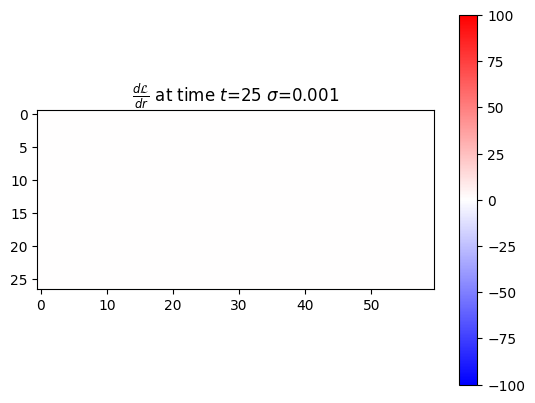

In [12]:
# plot an animation of dLdr_TSs at T=example time
fig, ax = plt.subplots()
# use a diverging colorbar with the center at 0
cmap = plt.cm.bwr
n = 256
all_colors = cmap(np.arange(n))
center = 128
cmap = cmap.from_list('CenteredBWR', all_colors)
cmap.set_bad(color='gray')

im = ax.imshow(dLdr_TSs[0][example_time].reshape(data_shape), cmap=cmap, vmin=-100, vmax=100)
plt.colorbar(im)
# put latex in title for dldr
plt.title(r'$\frac{d \mathcal{L}}{d r}$ at time $t$'+f'={example_time} '+r'$\sigma$'+f'={perturbed_noise}')
def update(i):
    im.set_array(dLdr_TSs[i][example_time].reshape(data_shape))
    return im, 
ani = animation.FuncAnimation(fig, update, frames=frames, interval=200)
ani.save('dLdr_TS.gif', writer='imagemagick')
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


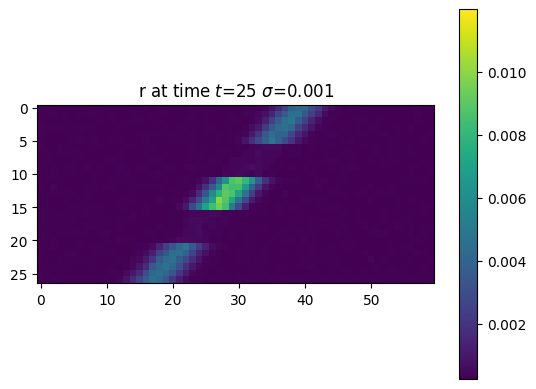

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(rs[0][example_time].reshape(data_shape), cmap='viridis')
plt.colorbar(im)
# put latex in title for dldr
plt.title(r'r at time $t$'+f'={example_time} '+r'$\sigma$'+f'={perturbed_noise}')
def update(i):
    im.set_array(rs[i][example_time].reshape(data_shape))
    return im, 
ani = animation.FuncAnimation(fig, update, frames=frames, interval=200)
ani.save('r_TS.gif', writer='imagemagick')
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


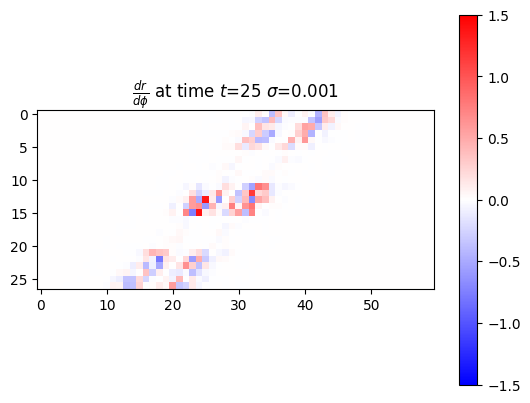

In [16]:
# plot an animation of dLdr_TSs at T=example time
fig, ax = plt.subplots()
im = ax.imshow(drdphi_TSPs[0][example_time,:,-1].reshape(data_shape),cmap=cmap, vmin=-1.5, vmax=1.5)
plt.colorbar(im)
plt.title(r'$\frac{d r}{d \phi}$ at time $t$'+f'={example_time} '+r'$\sigma$'+f'={perturbed_noise}')
def update(i):
    im.set_array(drdphi_TSPs[i][example_time,:,-1].reshape(data_shape))
    return im, 
ani = animation.FuncAnimation(fig, update, frames=10, interval=200)
ani.save('drdphi_TSP.gif', writer='imagemagick')
plt.show()


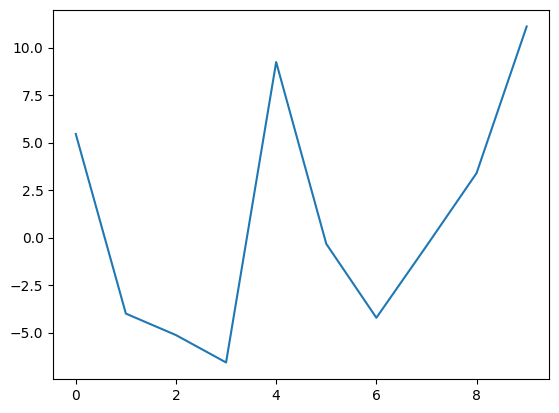

In [18]:
plt.plot([np.sum(grad[25,:,-1]) for grad in drdphi_TSPs])